### We aim to trian reward models from the dataset in Sample et al. Human MPTA Dataset (5'UTR polysome profiling)

- Paper link: https://www.nature.com/articles/s41587-019-0164-5
- Data link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE114002

## 1- Dataset preprocessing

In [1]:
import tempfile
import pandas as pd
import numpy as np
import wandb
wandb.login(host = "https://api.wandb.ai")
import grelu.lightning
import grelu.data.dataset
from grelu.visualize import plot_pred_scatter
from grelu.resources import artifacts, get_model_by_dataset, get_dataset_by_model
from grelu.resources import artifacts, get_model_by_dataset, get_dataset_by_model


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ma61sa136 (fderc_diffusion). Use `wandb login --relogin` to force relogin
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the dataset

In [2]:
df = pd.read_csv("artifacts/UTR-dataset/dataset.csv.gz")
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,utr,rl
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,-1.949703
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,-1.460671
2,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,-1.781243
3,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,-1.643680
4,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,-1.061173


## 2- Model training

In [3]:
import wandb
import torch
import grelu
import pandas as pd

from grelu.resources import artifacts, get_model_by_dataset, get_dataset_by_model

In [4]:
run = wandb.init(project='UTR-design', job_type='training', name='train')
run.name

'train'

### Train/Val/Test split 

In [5]:
import grelu.data.preprocess
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_test, df_val = train_test_split(df_test, test_size=0.5)
print(df_train.shape)
print(df_test.shape)

(260826, 2)
(32603, 2)


### Start the training!

In [7]:
model_params = {
    'model_type':'EnformerPretrainedModel',
    'n_tasks': 1,
    'n_transformers': 3,
}

train_params = {
    'task':'regression',
    'loss': 'MSE',
    'lr':1e-4,
    'logger': 'wandb',
    'batch_size': 256,
    'num_workers': 4,
    'devices': [4],
    'save_dir': 'experiment',
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True,
}

In [8]:
# Make labeled datasets
df_train = df_train[['utr',  'rl']]
df_val = df_val[['utr', 'rl']]
train_dataset = grelu.data.dataset.DFSeqDataset(df_train)
val_dataset   = grelu.data.dataset.DFSeqDataset(df_val)

# Build model
model = grelu.lightning.LightningModel(model_params=model_params, train_params=train_params)


Sequences will be extracted from columns ['utr']
Sequences will be extracted from columns ['utr']


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


In [9]:
# Train model
trainer = model.train_on_dataset(train_dataset, val_dataset)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████| 128/128 [00:03<00:00, 38.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.9980997443199158
         val_mse            0.9994034767150879
       val_pearson          0.04188229888677597
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 103 M  | train
1 | loss         | MSELoss                 | 0      | train
2 | activation   | Identity                | 0      | train
3 | val_metrics  | MetricCollection        | 0      | train
4 | test_metrics | MetricCollection        | 0      | train
5 | transform    | Identity                | 0      | train
-----------------------------------------------------------------
103 M     Trainable pa

/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


Epoch 9: 100%|██████████| 1019/1019 [00:43<00:00, 23.55it/s, v_num=r1h1, train_loss_step=0.407, train_loss_epoch=0.413]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1019/1019 [00:46<00:00, 21.73it/s, v_num=r1h1, train_loss_step=0.407, train_loss_epoch=0.413]


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▃▂▂▁▁
train_loss_step,█▇▆▆▄▇▅▄▄▄▃▄▃▃▂▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▃▂▁▁▂▂▁▂▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁▁
val_mse,█▆▄▃▂▂▂▁▁▁▁
val_pearson,▁▆▇████████
epoch,9
train_loss_epoch,0.41291
train_loss_step,0.37384
trainer/global_step,10189


***

## 3- Test model

In [10]:
test_dataset = grelu.data.dataset.DFSeqDataset(df_test)
model.test_on_dataset(test_dataset, devices=[1], num_workers=4)

Sequences will be extracted from columns ['utr']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 128/128 [00:02<00:00, 53.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6406435966491699
        test_mse            0.6400113701820374
      test_pearson          0.6169312000274658
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
rl,0.640011,0.616931


### Correlation plots for each cell type

In [11]:
preds = model.predict_on_dataset(test_dataset, devices=[2])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 128/128 [00:02<00:00, 58.85it/s]


### Correlation on test set

In [12]:
from grelu.visualize import plot_pred_scatter
import numpy as np
preds = model.predict_on_dataset(test_dataset, devices=[2])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 128/128 [00:01<00:00, 64.02it/s]


0.6169310512848855


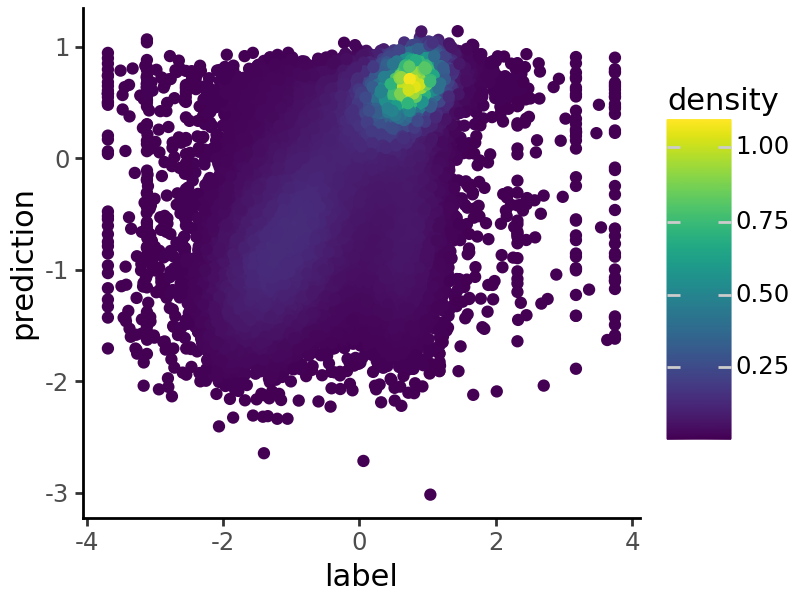

In [13]:
print(np.corrcoef(preds.squeeze(), test_dataset.labels.squeeze())[0][1])
plot_pred_scatter(preds, test_dataset.labels, density = True)